# Analysis

In the data cleaning notebook, I performed the appropriate manipulation to the initial dataframe containing information on the telecommunications company Syria tel

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
from sklearn.model_selection import train_test_split, GridSearchCV, StratifiedKFold
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier

I will import some functions I have used for previous analysis in order to customize reports later on the project.

In [3]:
from sklearn.metrics import roc_auc_score
def scores(model, X_train, X_val, y_train, y_val):
    train_prob = model.predict_proba(X_train)[:,1]
    val_prob = model.predict_proba(X_val)[:,1]
    train = roc_auc_score(y_train,train_prob)
    val = roc_auc_score(y_val,val_prob)
    print('train:',round(train,2),'test:',round(val,2))

In [4]:
def annot(fpr,tpr,thr):
    k=0
    for i,j in zip(fpr,tpr):
        if k %50 == 0:
            plt.annotate(round(thr[k],2),xy=(i,j), textcoords='data')
        k+=1

In [5]:
from sklearn.metrics import roc_curve
def roc_plot(model,X_train,y_train,X_val,y_val):
    train_prob = model.predict_proba(X_train)[:,1]
    val_prob = model.predict_proba(X_val)[:,1]
    plt.figure(figsize=(7,7))
    for data in [[y_train, train_prob],[y_val, val_prob]]: # ,[y_test, test_prob]
        fpr, tpr, threshold = roc_curve(data[0], data[1])
        plt.plot(fpr, tpr)
    annot(fpr, tpr, threshold)
    plt.plot([0, 1], [0, 1], color='navy', linestyle='--')
    plt.ylabel('TPR (power)')
    plt.xlabel('FPR (alpha)')
    plt.legend(['train','val'])
    plt.show()

In [6]:
def opt_plots(opt_model):
    opt = pd.DataFrame(opt_model.cv_results_)
    cols = [col for col in opt.columns if ('mean' in col or 'std' in col) and 'time' not in col]
    params = pd.DataFrame(list(opt.params))
    opt = pd.concat([params,opt[cols]],axis=1,sort=False)
    
    plt.figure(figsize=[15,4])
    plt.subplot(121)
    sns.heatmap(pd.pivot_table(opt,index='max_depth',columns='min_samples_leaf',values='mean_train_score')*100)
    plt.title('ROC_AUC - Training')
    plt.subplot(122)
    sns.heatmap(pd.pivot_table(opt,index='max_depth',columns='min_samples_leaf',values='mean_test_score')*100)
    plt.title('ROC_AUC - Validation')

First I will start by importing the clean dataframe as the new data

In [7]:
data = pd.read_csv("../Data/churn_data_clean")

The next step is to divide the dataframe into train, test and validation, for that we will use the train test split function from sklearn.

In [62]:
x = data.iloc[:,data.columns != "churn"]
y = data["churn"]

In [63]:
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size = 0.2, 
                                                    random_state = 42)

In [64]:
x_train_v, x_val, y_train_v, y_val = train_test_split(x_train, y_train, test_size = 0.2,
                                                     random_state = 42)

## Baseline Model

For the baseline model I will use the most simplistic subset of the variables in the dataset and train it with a logistic regression; in the following models the idea will be to improve the score by performing feature engineering and by changing the learner.

In [11]:
base_model = LogisticRegression()

In [12]:
base_model.fit(x_train_v, y_train_v)

/home/javier/.local/lib/python3.6/site-packages/sklearn/linear_model/_logistic.py:764: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


LogisticRegression()

train: 0.74 test: 0.75


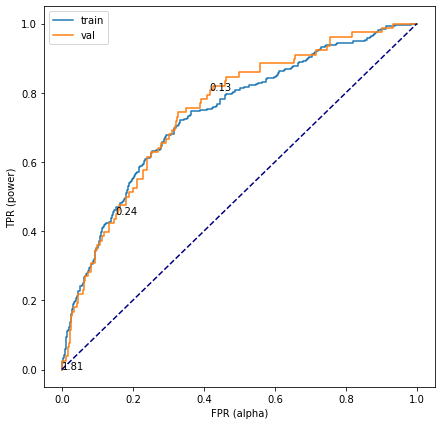

In [13]:
scores(base_model,x_train_v,x_val,y_train_v,y_val)
roc_plot(base_model, x_train_v, y_train_v, x_val, y_val)

## First Model

For the first model I will perform analysis using a decision tree classifier, with basic restraints.

In [14]:
first_model = DecisionTreeClassifier(random_state = 42, 
                                     max_depth = 5, 
                                     min_samples_leaf = 50)

In [15]:
first_model.fit(x_train_v, y_train_v)

DecisionTreeClassifier(max_depth=5, min_samples_leaf=50, random_state=42)

In [16]:
first_model.score(x_val, y_val)

0.900749063670412

train: 0.89 test: 0.87


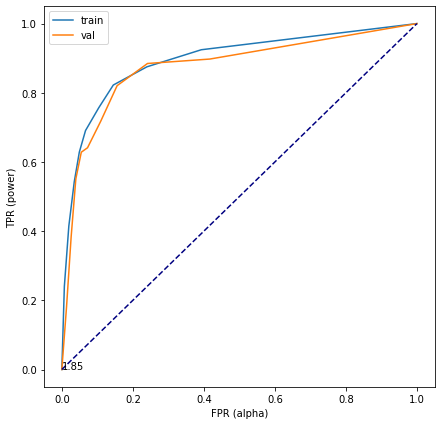

In [17]:
scores(first_model,x_train_v,x_val,y_train_v,y_val)
roc_plot(first_model, x_train_v, y_train_v, x_val, y_val)

This model appeared to have a score of 0.87, this is a score that denotes great predictive capacity for the model. But hyperparameter optimization and further learners can be applied in order to improve it.

### Features Importance

In [24]:
pd.DataFrame(first_model.feature_importances_, columns=['Importance'], index=x_train_v.columns)

,Importance
account_length,0.000000
international_plan,0.134643
voice_mail_plan,0.000000
number_vmail_messages,0.000000
total_day_calls,0.000000
total_day_charge,0.455182
total_eve_calls,0.000000
total_eve_charge,0.093484
total_night_calls,0.000000
total_night_charge,0.001991


## Second Model

For the second model, I will use grid search and stratified K fold in order to optimize the parameters of the decision tree. In this case, the max depth of the decision tree will range from 10 to 50 and the minimum sample leaf from 5 to 500. On the other hand the K fold will have 5 splits.

In [18]:
skf = StratifiedKFold(n_splits=5, random_state=42, shuffle=True)

train: 0.93 test: 0.89
{'max_depth': 6, 'min_samples_leaf': 20}


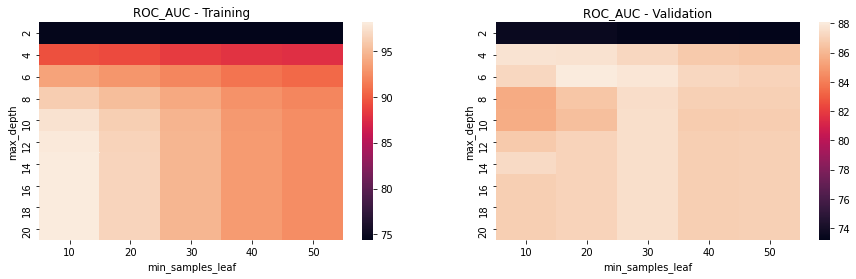

In [26]:
param_grid = {'max_depth':range(0,20+1,2),'min_samples_leaf':range(0,50+1,10)}

opt_model = GridSearchCV(first_model,param_grid,cv=skf,scoring='roc_auc',
                         return_train_score=True,n_jobs=-1)

opt_model.fit(x_train_v,y_train_v)
second_model = opt_model.best_estimator_

scores(second_model,x_train_v,x_val,y_train_v,y_val)
print(opt_model.best_params_)
opt_plots(opt_model)

train: 0.93 test: 0.89


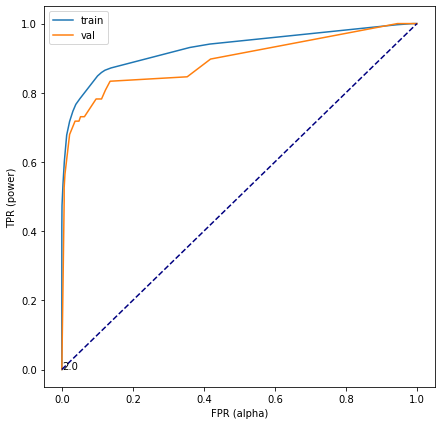

In [27]:
scores(second_model,x_train_v,x_val,y_train_v,y_val)
roc_plot(second_model,x_train_v,y_train_v,x_val,y_val)

As observed, the predicting capacity of the model improved to almost a 90% when performing the hyperparameter optimization, this process led me to believe that the best parameters fot the decision tree are a max depth of 6 branches and a minimum sample split of 20.

### Features Importance

In [28]:
pd.DataFrame(second_model.feature_importances_, columns=['Importance'], index=x_train_v.columns)

,Importance
account_length,0.000188
international_plan,0.091586
voice_mail_plan,0.000000
number_vmail_messages,0.070875
total_day_calls,0.002183
total_day_charge,0.333845
total_eve_calls,0.000000
total_eve_charge,0.103140
total_night_calls,0.012550
total_night_charge,0.007755


## Third model

For the third model I will use a random forest learner with basic restraints.

In [29]:
from sklearn.ensemble import RandomForestClassifier

In [32]:
third_model = RandomForestClassifier(n_estimators = 10, n_jobs = -1, random_state = 42)
third_model.fit(x_train_v, y_train_v)

RandomForestClassifier(n_estimators=10, n_jobs=-1, random_state=42)

train: 1.0 test: 0.89


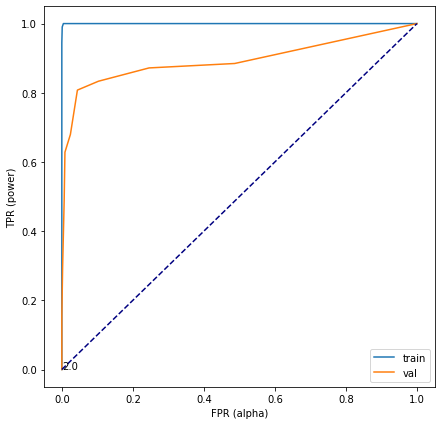

In [33]:
scores(third_model,x_train_v,x_val,y_train_v,y_val)
roc_plot(third_model,x_train_v,y_train_v,x_val,y_val)

As observed in the previous graph, there are clear indicators that the model with basic parameters shows overfitting for the validation sample.

### Feature importance

In [34]:
pd.DataFrame(third_model.feature_importances_, columns=['Importance'], index=x_train_v.columns)

,Importance
account_length,0.049375
international_plan,0.060373
voice_mail_plan,0.020173
number_vmail_messages,0.027176
total_day_calls,0.049965
total_day_charge,0.264847
total_eve_calls,0.045145
total_eve_charge,0.114560
total_night_calls,0.053958
total_night_charge,0.050979


Even though the model presented clear signs of overfitting, we can observe that as our model becomes more complex, it also becomes more precise, and all the variables start being relevant.

## Fourth Model

For the fourth and last model of the project I will use hyperpatameter optimization to refine the predictions and prevent overfitting.

Fitting 5 folds for each of 135 candidates, totalling 675 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 tasks      | elapsed:    3.7s
[Parallel(n_jobs=-1)]: Done  10 tasks      | elapsed:    4.1s
[Parallel(n_jobs=-1)]: Done  17 tasks      | elapsed:    5.3s
[Parallel(n_jobs=-1)]: Done  24 tasks      | elapsed:    6.4s
[Parallel(n_jobs=-1)]: Done  33 tasks      | elapsed:    8.3s
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:   10.3s
[Parallel(n_jobs=-1)]: Done  53 tasks      | elapsed:   11.7s
[Parallel(n_jobs=-1)]: Done  64 tasks      | elapsed:   13.4s
[Parallel(n_jobs=-1)]: Done  77 tasks      | elapsed:   16.0s
[Parallel(n_jobs=-1)]: Done  90 tasks      | elapsed:   18.8s
[Parallel(n_jobs=-1)]: Done 105 tasks      | elapsed:   20.7s
[Parallel(n_jobs=-1)]: Done 120 tasks      | elapsed:   23.4s
[Parallel(n_jobs=-1)]: Done 137 tasks      | elapsed:   27.0s
[Parallel(n_jobs=-1)]: Done 154 tasks      | elapsed:   29.5s
[Parallel(n_jobs=-1)]: Done 173 tasks      | elapsed:   

train: 0.93 test: 0.89
{'max_depth': 21, 'min_samples_leaf': 5, 'n_estimators': 30}


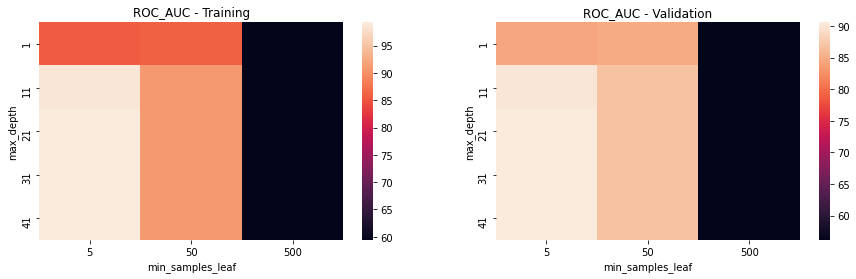

In [44]:
param_grid = {'max_depth':range(1,50+1,10),'min_samples_leaf':[5,50,500], 'n_estimators':range(10, 100, 10)}

opt_model = GridSearchCV(third_model,param_grid,cv=skf,scoring='roc_auc',return_train_score=True,n_jobs=-1,verbose=10)
opt_model.fit(x_train_v,y_train_v)
fourth_model = opt_model.best_estimator_

scores(second_model,x_train_v,x_val,y_train_v,y_val)
print(opt_model.best_params_)
opt_plots(opt_model)

From the above charts we can withdraw some hypothesis, the optimal minimum sample leaf should be below 50 and the maximum depth of the trees must be above 10, this is due to the fact that the best areas under the curve are achieved in between these intervals.

Fitting 5 folds for each of 360 candidates, totalling 1800 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 tasks      | elapsed:    1.0s
[Parallel(n_jobs=-1)]: Done  10 tasks      | elapsed:    1.7s
[Parallel(n_jobs=-1)]: Done  17 tasks      | elapsed:    2.7s
[Parallel(n_jobs=-1)]: Done  24 tasks      | elapsed:    3.7s
[Parallel(n_jobs=-1)]: Done  33 tasks      | elapsed:    4.8s
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:    6.1s
[Parallel(n_jobs=-1)]: Done  53 tasks      | elapsed:    7.6s
[Parallel(n_jobs=-1)]: Done  64 tasks      | elapsed:    9.2s
[Parallel(n_jobs=-1)]: Done  77 tasks      | elapsed:   11.2s
[Parallel(n_jobs=-1)]: Done  90 tasks      | elapsed:   12.6s
[Parallel(n_jobs=-1)]: Done 105 tasks      | elapsed:   14.8s
[Parallel(n_jobs=-1)]: Done 120 tasks      | elapsed:   17.0s
[Parallel(n_jobs=-1)]: Done 137 tasks      | elapsed:   19.4s
[Parallel(n_jobs=-1)]: Done 154 tasks      | elapsed:   21.4s
[Parallel(n_jobs=-1)]: Done 173 tasks      | elapsed:   

train: 0.93 test: 0.89
{'max_depth': 20, 'min_samples_leaf': 5, 'n_estimators': 30}


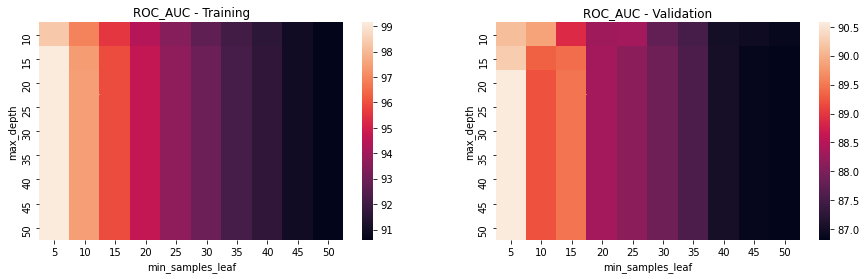

In [45]:
param_grid = {'max_depth':range(10,50+1,5),'min_samples_leaf':range(5,50+1,5), 'n_estimators':range(10, 50, 10)}

opt_model = GridSearchCV(third_model,param_grid,cv=skf,scoring='roc_auc',return_train_score=True,n_jobs=-1,verbose=10)
opt_model.fit(x_train_v,y_train_v)
fourth_model = opt_model.best_estimator_

scores(second_model,x_train_v,x_val,y_train_v,y_val)
print(opt_model.best_params_)
opt_plots(opt_model)

After further indepth analysis is performed, we conclude that the model reaches is optimum levels by setting the parameters of the random forest trees to a maximum depth of 20 a minimum sample per leaf of 5 and 30 as the number of estimators.

### Features Importance

In [50]:
pd.DataFrame(fourth_model.feature_importances_, columns=['Importance'], index=x_train_v.columns)

,Importance
account_length,0.037722
international_plan,0.098657
voice_mail_plan,0.022486
number_vmail_messages,0.020341
total_day_calls,0.034839
total_day_charge,0.312981
total_eve_calls,0.029206
total_eve_charge,0.090292
total_night_calls,0.040468
total_night_charge,0.040042


## Conclusion and final model

For the conclusion I will train the most efficient model in the entire train set and then calculate its area under the curve with the test set.

The selected model is the second model, the decision tree with hyperparameters, because even though it has the same scores for train and validation than the last model, it is much more simple and faster to perform.

In [65]:
final_model = DecisionTreeClassifier(min_samples_leaf = 20, max_depth = 6, random_state = 42)

In [66]:
final_model.fit(x_train, y_train)

DecisionTreeClassifier(max_depth=6, min_samples_leaf=20, random_state=42)

train: 0.93 test: 0.9


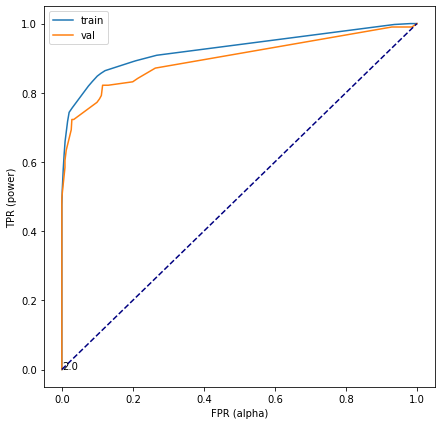

In [67]:
scores(final_model,x_train,x_test,y_train,y_test)
roc_plot(final_model,x_train,y_train,x_test,y_test)

### Final Model Feature Importance

In [68]:
pd.DataFrame(final_model.feature_importances_, columns=['Importance'], index=x_train_v.columns)

,Importance
account_length,0.000000
international_plan,0.102239
voice_mail_plan,0.000000
number_vmail_messages,0.060994
total_day_calls,0.000793
total_day_charge,0.313608
total_eve_calls,0.003028
total_eve_charge,0.128828
total_night_calls,0.000000
total_night_charge,0.013601


To conclude, in the above table we see the relative importance in the prediction of customer churn in Syria Tel, some factors to take into account:

The most important variable in our model is the total charge per day, it seems to explain one third of the prediction this is a must to be considered by Syria Tel as maybe their efforts should go in order to reduce their costs henceforth reducing the price for their customers instead of trying to give a better service, further analysis must be performed and a user survey should be considered in order to know whether they are really price sensitive.

Another important factor seems to be the presence of an international plan for the users, further analysis must be performed in this aspect, this can be caused by several factors, the charge per international call or some malfunctioning while trying to connect with people in other countries.

A final aspect worth taking into account is that the above prediction measures the area under the curve for the model, but for predictive reasoning we must set a threshold so that the cost for the company is minimized. For this purpose, more data reagarding the project is needed, for example the cost of falsely predicting that a customer will churn or the cost of implementing change in prices if the model predicts false negatives.